##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Convolutional Neural Network (CNN)

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/cnn">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/cnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates training a simple [Convolutional Neural Network](https://developers.google.com/machine-learning/glossary/#convolutional_neural_network) (CNN) to classify [CIFAR images](https://www.cs.toronto.edu/~kriz/cifar.html). Because this tutorial uses the [Keras Sequential API](https://www.tensorflow.org/guide/keras/overview), creating and training our model will take just a few lines of code.


### Import TensorFlow

In [2]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

### Download and prepare the CIFAR10 dataset


The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

170508288/170498071 [==============================] - 97s 1us/step


### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image.


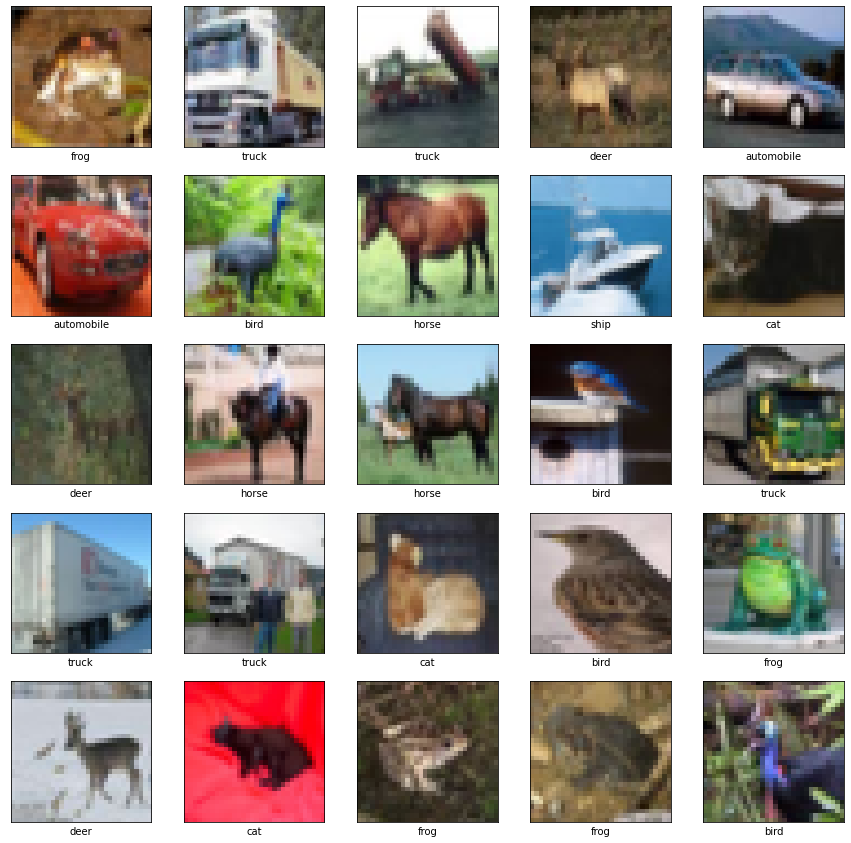

In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

### Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure our CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument `input_shape` to our first layer.


In [6]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

Let's display the architecture of our model so far.

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
Total params: 56,320
Trainable params: 56,320
Non-traina

Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically,  as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

### Add Dense layers on top
To complete our model, you will feed the last output tensor from the convolutional base (of shape (4, 4, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten (or unroll) the 3D output to 1D,  then add one or more Dense layers on top. CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs and a softmax activation.

In [9]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

Here's the complete architecture of our model.

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

As you can see, our (4, 4, 64) outputs were flattened into vectors of shape (1024) before going through two Dense layers.

### Compile and train the model

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 [==============================] - 72s 45ms/step - loss: 1.5521 - accuracy: 0.4325 - val_loss: 1.2761 - val_accuracy: 0.5465
Epoch 2/10
1563/1563 [==============================] - 70s 45ms/step - loss: 1.1854 - accuracy: 0.5790 - val_loss: 1.0805 - val_accuracy: 0.6168
Epoch 3/10
1563/1563 [==============================] - 71s 45ms/step - loss: 1.0302 - accuracy: 0.6367 - val_loss: 0.9927 - val_accuracy: 0.6505
Epoch 4/10
1563/1563 [==============================] - 70s 45ms/step - loss: 0.9362 - accuracy: 0.6710 - val_loss: 0.9608 - val_accuracy: 0.6624
Epoch 5/10
1563/1563 [==============================] - 70s 45ms/step - loss: 0.8607 - accuracy: 0.6992 - val_loss: 0.9279 - val_accuracy: 0.6735
Epoch 6/10
1563/1563 [==============================] - 71s 45ms/step - loss: 0.7988 - accuracy: 0.7208 - val_loss: 0.9219 - val_accuracy: 0.6822
Epoch 7/10
1563/1563 [==============================] - 71s 45ms/step - loss: 0.7511 - accuracy: 0.7373 - val_loss: 0.9345 -

### Evaluate the model

313/313 - 5s - loss: 0.9043 - accuracy: 0.6966 - 5s/epoch - 17ms/step


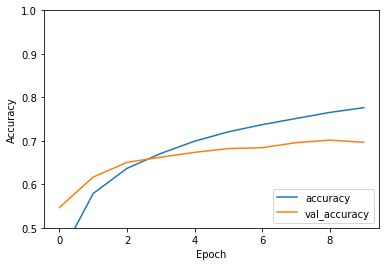

In [12]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [13]:
print(test_acc)

0.6966000199317932


Our simple CNN has achieved a test accuracy of over 70%. Not bad for a few lines of code! For another CNN style, see an example using the Keras subclassing API and a `tf.GradientTape` [here](https://www.tensorflow.org/tutorials/quickstart/advanced).

### LeNet-5

#### Create the convolutional base

In [15]:
lenet_5_model = models.Sequential()
lenet_5_model.add(layers.Conv2D(6, kernel_size=5, strides=1,  activation='tanh',  input_shape=(32, 32, 3), padding='same'))
lenet_5_model.add(layers.AveragePooling2D())
lenet_5_model.add(layers.Conv2D(16, kernel_size=5, strides=1, activation='tanh', padding='valid'))
lenet_5_model.add(layers.AveragePooling2D())
lenet_5_model.add(layers.Conv2D(120, kernel_size=5, strides=1, activation='tanh', padding='valid'))

#### Add Dense layers on top

In [16]:
lenet_5_model.add(layers.Flatten())
lenet_5_model.add(layers.Dense(84, activation='tanh'))
lenet_5_model.add(layers.Dense(10, activation='softmax'))

#### Compile and train the model

In [19]:
lenet_5_model.compile(optimizer='adam', loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [ ]:
history = lenet_5_model.fit(train_images, train_labels, epochs=50, 
                    validation_data=(test_images, test_labels))

Epoch 1/50
1563/1563 [==============================] - 29s 19ms/step - loss: 1.0490 - accuracy: 0.6301 - val_loss: 1.3194 - val_accuracy: 0.5465
Epoch 2/50
1563/1563 [==============================] - 31s 20ms/step - loss: 1.0116 - accuracy: 0.6410 - val_loss: 1.3472 - val_accuracy: 0.5393
Epoch 3/50
1563/1563 [==============================] - 11339s 7s/step - loss: 0.9755 - accuracy: 0.6546 - val_loss: 1.3456 - val_accuracy: 0.5468
Epoch 4/50
1563/1563 [==============================] - 6709s 4s/step - loss: 0.9444 - accuracy: 0.6642 - val_loss: 1.3509 - val_accuracy: 0.5487
Epoch 5/50
1563/1563 [==============================] - 52s 33ms/step - loss: 0.9088 - accuracy: 0.6792 - val_loss: 1.3544 - val_accuracy: 0.5510
Epoch 6/50
1563/1563 [==============================] - 53s 34ms/step - loss: 0.8823 - accuracy: 0.6878 - val_loss: 1.3673 - val_accuracy: 0.5486
Epoch 7/50
1563/1563 [==============================] - 54s 35ms/step - loss: 0.8462 - accuracy: 0.7001 - val_loss: 1.3919 

#### Evaluate the model

313/313 - 2s - loss: 1.2997 - accuracy: 0.5496 - 2s/epoch - 7ms/step


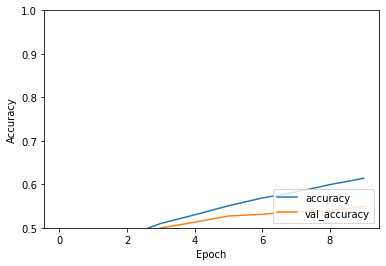

In [21]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = lenet_5_model.evaluate(test_images,  test_labels, verbose=2)